In [4]:
#pip install fastbook

In [5]:
from fastbook import *

In [6]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [7]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

We've successfully downloaded the URLs of 200 grizzly bears (or, at least, images that Bing Image Search finds for that search term).

Let's look at one:


In [20]:
dest = Path('images/grizzly.jpg')
if not dest.exists(): download_url(ims[1], dest, show_progress=False)

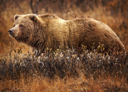

In [21]:
im = Image.open(dest)
im.to_thumb(128,128)

This seems to have worked nicely, so let's use fastai's download_images to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [23]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [24]:
if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok= True)
    results = search_images_ddg(f'{o} bear')
    download_images(dest, urls= results)


['https://cdn.wallpapersafari.com/7/23/ucA5r6.jpg', 'https://1.bp.blogspot.com/-l-Y6zD_KF6o/UQN3jPgigAI/AAAAAAAAFcU/HOKJWQmNjo4/s1600/Grizzly+Bear-2013-0pic-05.jpg', 'https://www.expeditionsalaska.com/wp-content/uploads/2017/01/12_mar6100.jpg', 'https://eskipaper.com/images/pictures-of-grizzly-bears-6.jpg', 'http://feelgrafix.com/data_images/out/9/824580-grizzly-bear-pictures.jpg', 'https://www.publicdomainpictures.net/pictures/310000/nahled/grizzly-bear-1564257594hjC.jpg', 'https://media.salon.com/2014/03/Grizzly-Bear-1900x1200.jpg', 'https://www.goodfreephotos.com/albums/animals/mammals/grizzly-bear-in-the-wild.jpg', 'http://alaskagirlatheart.com/wp-content/uploads/2012/05/grizzly-1.jpg', 'https://www.moose-r-us.com/wp-content/uploads/2022/08/grizzalaska5.jpg', 'https://hamactrading.com/wp-content/uploads/2023/04/REZ130011-G.jpg', 'https://komonews.com/resources/media2/16x9/full/1015/center/80/4d227d7a-3043-482d-ae85-dcbfff270bca-large16x9_grizzlybear.jpg', 'https://pics.craiyon.com/

Our folder has image files, as we'd expect:

In [25]:
fns = get_image_files(path)
fns

(#546) [Path('bears/black/acfb4516-9658-461d-b297-327f116c45d3.jpg'),Path('bears/black/1f00df36-3661-4726-b9e1-8343895bc09e.jpg'),Path('bears/black/a974f777-c072-4dd9-9a98-e957e13fb5dc.JPG'),Path('bears/black/0a49fbfa-6984-4608-a422-34ff052c82ac.jpg'),Path('bears/black/f82b8b44-76fc-47e0-98cf-70dbfb7f60d4.jpg'),Path('bears/black/419206f9-4b61-4f75-9306-d47ad44e42ea.jpg'),Path('bears/black/e011a8d6-523f-472e-8b10-0ac15a0c4d16.jpg'),Path('bears/black/77e11bc0-f2d7-4b34-8d98-ff9f0602ccbe.jpg'),Path('bears/black/5f19f88b-c382-46a4-a917-43369d7f078b.jpg'),Path('bears/black/bcda181e-d907-4fb2-aa8b-89e525c0ac9a.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [26]:
failed = verify_images(fns)
failed

(#17) [Path('bears/black/09196313-e282-4700-ad9d-b182b111bcfd.jpg'),Path('bears/black/8e05efee-baa5-4299-b399-48d74483f7a9.jpg'),Path('bears/black/8a69fa2b-bba8-4ba2-9927-4da18306b351.jpg'),Path('bears/grizzly/89cef773-8304-4e1c-8e0f-e406090784de.jpg'),Path('bears/grizzly/f4c76f48-d7d5-478d-a094-fbf64d1e36d0.JPG'),Path('bears/grizzly/863a6ec8-7196-4412-ac69-4d940de064da.jpg'),Path('bears/grizzly/9e63b9a0-66cb-42d0-857b-b2bafd004839.jpg'),Path('bears/teddy/1e716bca-a473-451c-b766-607bf9c0a539.jpg'),Path('bears/teddy/3dfe20be-1eec-4770-8778-5a2e2a9015e2.jpg'),Path('bears/teddy/fac3c0e8-ba89-4dea-96bd-4e478cc900c5.jpg')...]

To remove all the failed images, you can use unlink on each of them. Note that, like most fastai functions that return a collection, verify_images returns an object of type L, which includes the map method. This calls the passed function on each element of the collection:

In [27]:
failed.map(Path.unlink);

To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:

*   What kinds of data we are working with
*   How to get the list of items
*   How to label these items
*   How to create the validation set

So far we have seen a number of factory methods for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the data block API. With this API you can fully customize every stage of the creation of your DataLoaders. Here is what we need to create a DataLoaders for the dataset that we just downloaded:

In [29]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [30]:
# A DataLoaders includes validation and training DataLoaders.
# DataLoader is a class that provides batches of a few items at a time to the GPU.
dls = bears.dataloaders(path)

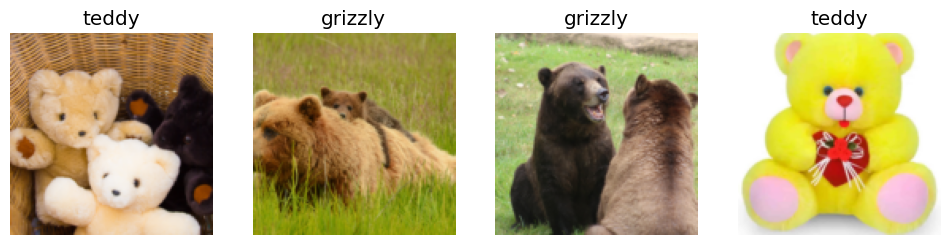

In [31]:
dls.valid.show_batch(max_n=4, nrows=1)

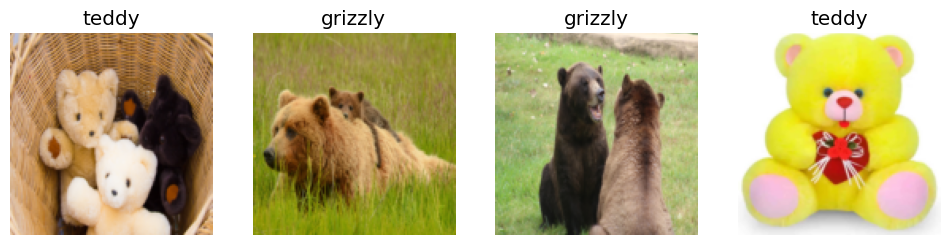

In [32]:
#By default Resize crops the images to fit a square shape of the size requested,
# using the full width or height. This can result in losing some important details.
# Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

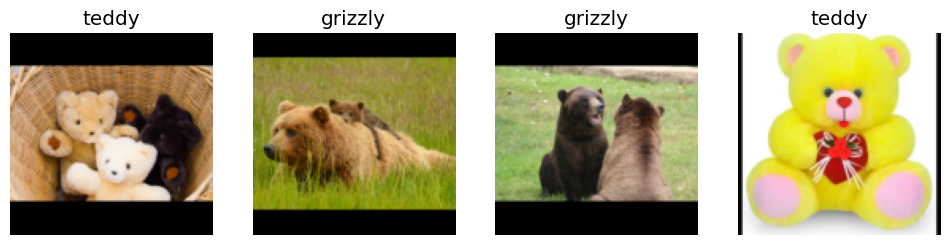

In [33]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


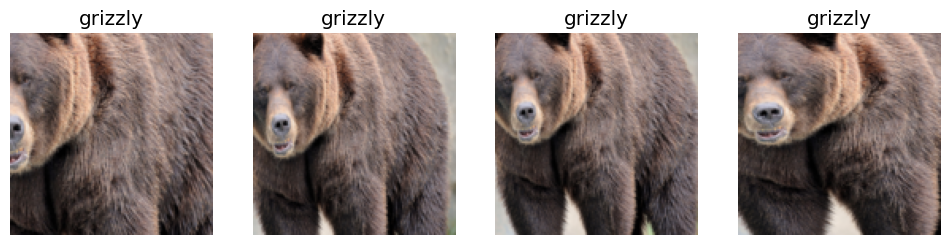

In [34]:
#Here's another example where we replace Resize with RandomResizedCrop,
# which is the transform that provides the behavior we just described.
#The most important parameter to pass in is min_scale, which determines how much of
#the image to select at minimum each time:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)


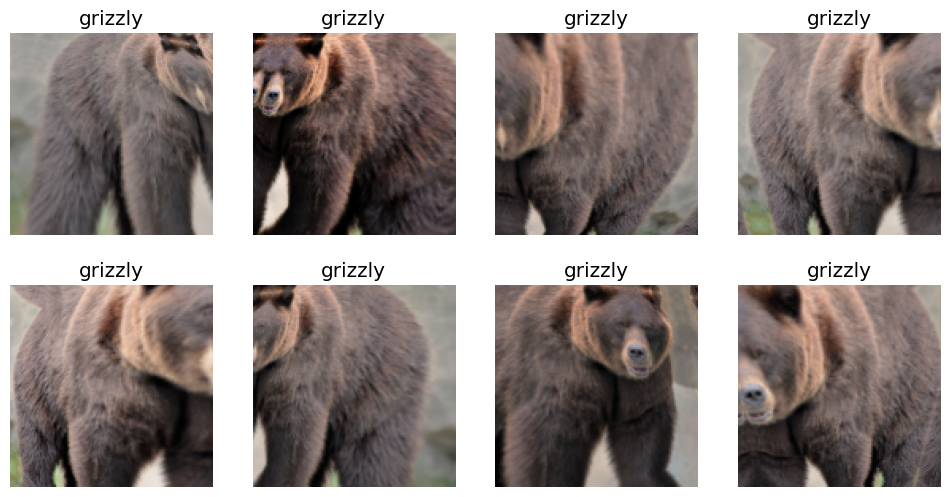

In [35]:
# Data Augmentation
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [36]:
# Training the Model, and Using It to Clean Your Data
# We don't have a lot of data for our problem (200 pictures of each sort of bear at most),
#so to train our model, we'll use RandomResizedCrop with an image size of 224 px,
#which is fairly standard for image classification, and default aug_transforms:

bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)


In [37]:
# We can now create our Learner and fine-tune it in the usual way:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.7MB/s]


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

In [38]:
# Now let's see whether the mistakes the model is making are mainly thinking
# that grizzlies are teddies (that would be bad for safety!), or that grizzlies
#are black bears, or something else. To visualize this, we can create a confusion matrix:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

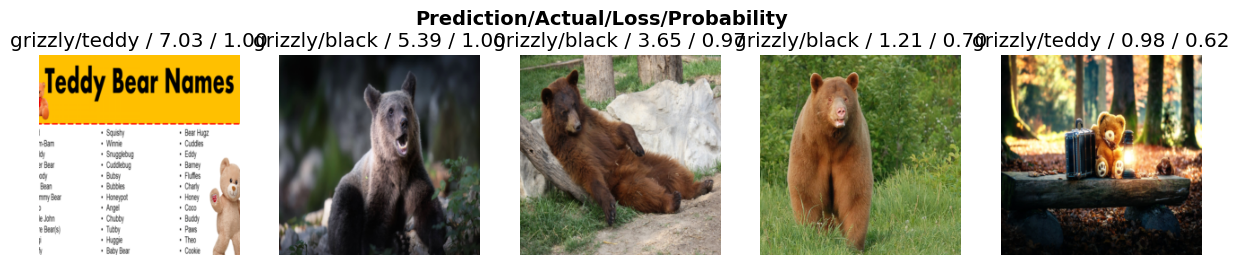

In [39]:
#For now, plot_top_losses shows us the images with the highest loss in our dataset.
#As the title of the output says, each image is labeled with four things: prediction,
#actual (target label), loss, and probability. The probability here is the confidence level,
#from zero to one, that the model has assigned to its prediction:
interp.plot_top_losses(5, nrows=1)

In [45]:
from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner

In [46]:
#fastai includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose
#a category and the training versus validation set and view the highest-loss images (in order),
#along with menus to allow images to be selected for removal or relabeling:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [47]:
#ImageClassifierCleaner doesn't actually do the deleting or changing of labels for you;
#it just returns the indices of items to change. So, for instance, to delete (unlink) all images selected
# for deletion, we would run:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#To move images for which we've selected a different category, we would run:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Turning the Model into an Online Application

In [ ]:
# Using the Model for Inference:
# When you call export, fastai will save a file called "export.pkl":
learn.export()

In [ ]:
#Let's check that the file exists, by using the ls method that fastai adds to Python's Path class:
path = Path()
path.ls(file_exts='.pkl')
